## Imports

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import *

WORLDX, WORLDY = 10, 6 

## Remote API Functions

In [49]:
# create a client to connect to zmqRemoteApi server:
# (creation arguments can specify different host/port,
# defaults are host='localhost', port=23000)
client = RemoteAPIClient()

# get a remote object:
sim = client.require('sim')

# call API function fo test:
pioneer = sim.getObject('/Pioneer_p3dx')
print("Printando o pioninho: " + str(pioneer))

Printando o pioninho: 15


## Gradiente

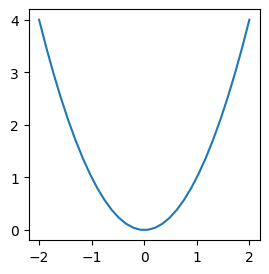

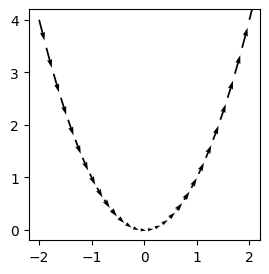

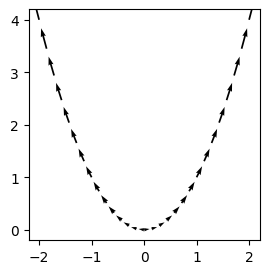

In [50]:
# Atenção com a ordem dos pontos
xn = np.linspace(0, -2, 15)
xp = np.linspace(0, 2, 15)
x =  np.linspace(-2, 2, 30)
y = x**2


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
plt.plot(x, y)


dx = np.gradient(x)
dy = np.gradient(y)

fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')
ax.quiver(x, y, dx, dy)


fig = plt.figure(figsize=(6,3), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

y = xn**2
dx = np.gradient(xn)
dy = np.gradient(y)
ax.quiver(xn, y, dx, dy)

y = xp**2
dx = np.gradient(xp)
dy = np.gradient(y)
ax.quiver(xp, y, dx, dy)

## Attraction force

(0.0, 6.0)

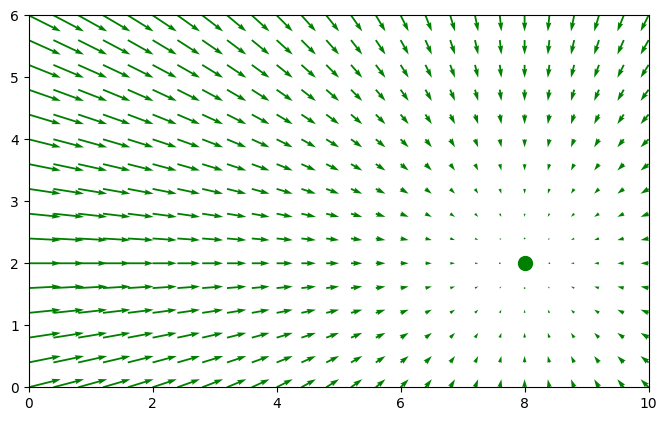

In [51]:
def att_force(q, goal, katt=.01):
    return katt*(np.array(goal) - np.array(q))

goal = np.array([8, 2])

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

XX, YY = np.meshgrid(np.arange(0, WORLDX+.4, .4), np.arange(0, WORLDY+.4, .4))
XY = np.dstack([XX, YY]).reshape(-1, 2)

Fatt = att_force(XY, goal)
Fatt_x = Fatt[:,0] 
Fatt_y = Fatt[:,1]

ax.quiver(XX, YY, Fatt_x, Fatt_y, color='g')

plt.plot(goal[0], goal[1], 'og', markersize=10)
    
ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

## Repulsion force

(0.0, 6.0)

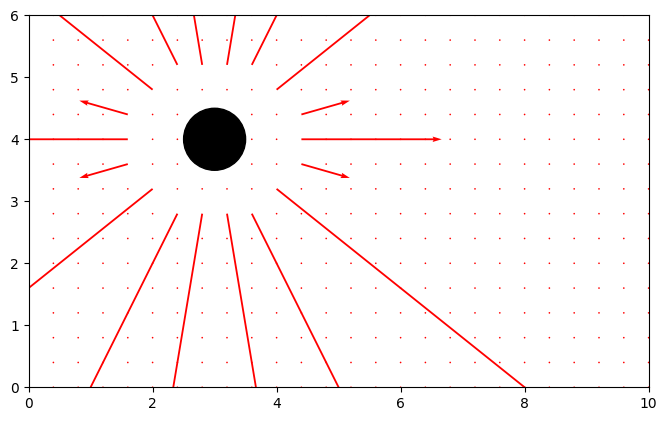

In [52]:
def rep_force(q, obs, R=1, krep=.1):
    
    # Obstáculo: (x, y, r)
    v = q - obs[0:2]
    d = np.linalg.norm(v, axis=1) - obs[2]
    d = d.reshape((len(v) ,1))
    
    rep = (1/d**2)*((1/d)-(1/R))*(v/d)    
    
    invalid = np.squeeze(d > R)
    rep[invalid, :] = 0
    
    return krep*rep

# Obstáculo: (x, y, r)
obs = np.array([3, 4, .5])

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

Frep = rep_force(XY, obs)
Frep_x = np.copy(Frep[:,0])  # Cuidado com as referências
Frep_y = np.copy(Frep[:,1])  # Cuidado com as referências

# Threshold para visualização
fmax = .15
Fm = np.linalg.norm(Frep, axis=1)
Frep_x[Fm > fmax], Frep_y[Fm > fmax] = 0, 0

ax.quiver(XX, YY, Frep_x, Frep_y, color='r')
ax.add_patch(patches.Circle((obs[0], obs[1]), obs[2], color='k'))

ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

## Força Total

(0.0, 6.0)

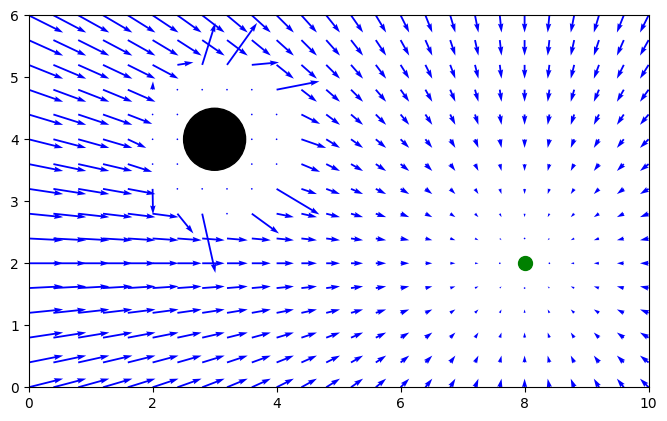

In [53]:
Ft = Fatt + Frep

# Normalização
# Ft = Ft / np.linalg.norm(Ft, axis=1).reshape((len(Ft), 1))

Ft_x = Ft[:,0]
Ft_y = Ft[:,1]

# Threshold para visualização
fmax = .15
Fm = np.linalg.norm(Ft, axis=1)
Ft_x[Fm > fmax], Ft_y[Fm > fmax] = 0, 0

fig = plt.figure(figsize=(8,5), dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.quiver(XX, YY, Ft_x, Ft_y, color='b')
plt.plot(goal[0], goal[1], 'og', markersize=10)
ax.add_patch(patches.Circle((obs[0], obs[1]), obs[2], color='k'))

ax.set_xlim(0, WORLDX)
ax.set_ylim(0, WORLDY)

## Leitura do sensor

In [54]:
def readSensorData(clientId=-1, 
                    range_data_signal_id="hokuyo_range_data", 
                    angle_data_signal_id="hokuyo_angle_data"):
    # the first call should be non-blocking to avoid getting out-of-sync angle data
    string_range_data = sim.getStringSignal(range_data_signal_id)

    # the second call should block to avoid out-of-sync scenarios
    # between your python script and the simulator's main loop
    # (your script may be slower than the simulator's main loop, thus
    # slowing down data processing)
    string_angle_data = sim.getStringSignal(angle_data_signal_id)

    # check if both data were obtained correctly
    if string_range_data is not None and string_angle_data is not None:
        # unpack data from range and sensor messages
        raw_range_data = sim.unpackFloatTable(string_range_data)
        raw_angle_data = sim.unpackFloatTable(string_angle_data)

        return raw_range_data, raw_angle_data

    # return None in case nothing was obtained from the simulator
    return None

# Função para desenhar os dados do laser
def draw_laser_data(laser_data, max_sensor_range=5):
    fig = plt.figure(figsize=(6,6), dpi=100)
    ax = fig.add_subplot(111, aspect='equal')

    # for ang, dist in laser_data:
    for i in range(len(laser_data)):
        ang, dist = laser_data[i]
        # Quando o feixe não acerta nada, retorna o valor máximo (definido na simulação)
        # Logo, usar um pequeno limiar do máximo para considerar a leitura
        if (max_sensor_range - dist) > 0.1:
            x = dist * np.cos(ang)
            y = dist * np.sin(ang)
            c = 'r'
            if ang < 0:    
                c = 'b'
            ax.plot(x, y, 'o', color=c)

    ax.plot(0, 0, 'k>', markersize=10)
        
    ax.grid()
    ax.set_xlim([-max_sensor_range, max_sensor_range])
    ax.set_ylim([-max_sensor_range, max_sensor_range])

#### Funções auxiliares para coleta de dados da API do CoppeliaSim

In [55]:
# Função para recuperar as posições dos objetos no cenário do CoppeliaSim
def get_object_position(sim, object_name):
    return sim.getObjectPosition(sim.getObject(object_name), -1)
# O mesmo para orientação
def get_object_orientation(sim, object_name):
    return sim.getObjectOrientation(sim.getObject(object_name), -1)

Connected to remote API server
Printando o pioninho: 15
Posição do robô: [1.355322719631228, -4.932018911729971, 0.13865491189545434]
Matriz de transformação do laser em relação ao robô: [ 9.99999998e-01  8.26041269e-17  5.52807687e-05 -8.88178420e-16
 -2.67358784e-10  1.00000000e+00  4.83637813e-06 -8.88178420e-16
 -5.52807687e-05 -4.83637814e-06  9.99999998e-01  1.50000006e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
Matriz de transformação do robô em relação ao mundo: [ 4.24312410e-02 -9.99099373e-01 -1.79774681e-04  1.35532649e+00
  9.99095555e-01  4.24315760e-02 -2.76290490e-03 -4.93213638e+00
  2.76804468e-03 -6.23786012e-05  9.99996167e-01  1.38654910e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
Matriz de transformação do robô em relação ao laser: [[ 9.99999998e-01 -2.67358784e-10 -5.52807687e-05  8.29211563e-06]
 [ 8.26041269e-17  1.00000000e+00 -4.83637814e-06  7.25456751e-07]
 [ 5.52807687e-05  4.83637813e-06  9.99999998e-01 -

ValueError: operands could not be broadcast together with shapes (3,) (684,2) 

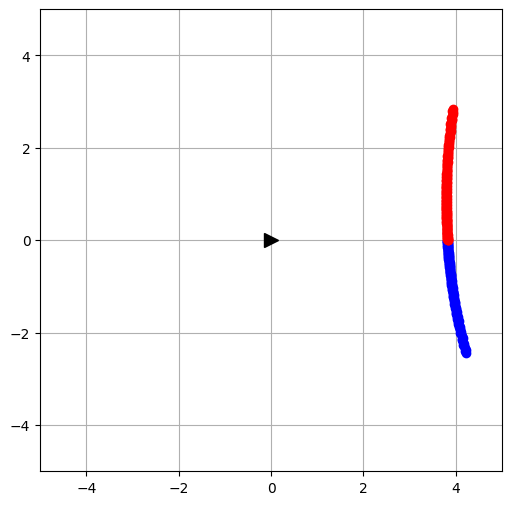

In [58]:
# Conectando-se ao CoppeliaSim
# Run a simulation in asynchronous mode:
clientID = sim.startSimulation()

if clientID != -1:
    print("Connected to remote API server")

    # Handle para o ROBÔ    
    laser_robot = sim.getObject('/Pioneer_p3dx')
    print("Printando o pioninho: " + str(laser_robot))

    #Handle para o LASER
    laser = sim.getObject('/Pioneer_p3dx/fastHokuyo')

    # Handle para as juntas das RODAS
    motorLeft = sim.getObject('/Pioneer_p3dx_leftMotor')
    motorRight = sim.getObject('/Pioneer_p3dx_rightMotor')

    laser_position = get_object_position(sim, '/Pioneer_p3dx/fastHokuyo')
    laser_orientation = get_object_orientation(sim, '/Pioneer_p3dx/fastHokuyo')

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    # Posição do robô
    laser_robot_position = get_object_position(sim, '/Pioneer_p3dx')
    print("Posição do robô: " + str(laser_robot_position))
    # Orientação do robô
    laser_robot_orientation = get_object_orientation(sim, '/Pioneer_p3dx')

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"

    # Prosseguindo com a leitura dos dados
    raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
    laser_data = np.array([raw_angle_data, raw_range_data]).T

    # Plotando os dados do sensor
    if laser_range_data is not None and laser_angle_data is not None:
        draw_laser_data(laser_data)

    # Matriz de transformação Trl (laser → robô)
    Trl = sim.getObjectMatrix(laser, laser_robot) # Matriz de transformação do laser em relação ao robô
    Trl = np.hstack([Trl, [0, 0, 0, 1]])
    print("Matriz de transformação do laser em relação ao robô: " + str(Trl))

    # Matriz de transformação Twr (robô → mundo)
    Twr = sim.getObjectMatrix(laser_robot, -1) # Matriz de transformação do robô em relação ao mundo
    Twr = np.hstack([Twr, [0, 0, 0, 1]])
    print("Matriz de transformação do robô em relação ao mundo: " + str(Twr))

    # Matriz de transformação Tlr (robô → laser)
    Tlr = np.linalg.inv(Trl.reshape(4, 4))
    print("Matriz de transformação do robô em relação ao laser: " + str(Tlr))

    L = 0.381 # Distância entre as rodas
    r = 0.0975 # Raio das rodas

    following = False

if clientID != -1:
    print("Connected to remote API server")

    # Definindo um Goal
    goal = np.array([8, 2, 0])

    # Handle para o ROBÔ    
    laser_robot = sim.getObject('/Pioneer_p3dx')

    #Handle para o LASER
    laser = sim.getObject('/Pioneer_p3dx/fastHokuyo')

    # Handle para as juntas das RODAS
    motorLeft = sim.getObject('/Pioneer_p3dx_leftMotor')
    motorRight = sim.getObject('/Pioneer_p3dx_rightMotor')

    # Handle para os dados do LASER
    laser_range_data = "hokuyo_range_data"
    laser_angle_data = "hokuyo_angle_data"


    while True:
        # Ler os dados do sensor
        raw_range_data, raw_angle_data = readSensorData(clientID, laser_range_data, laser_angle_data)
        laser_data = np.array([raw_angle_data, raw_range_data]).T

        # Calcular as forças de atração e repulsão
        print('Laser robot position: ', laser_robot_position)
        print('Goal: ', goal)
        Fatt = att_force(laser_robot_position, goal)
        Frep = rep_force(laser_data, obs)
        Ft = Fatt + Frep

        # Calcular a força total
        Ft = Ft / np.linalg.norm(Ft)
        Ft = np.dot(Twr[0:2, 0:2], Ft)
        Ft = np.hstack([Ft, [0, 0]])

        # Setando constantes
        kv = 1
        kw = 2

        # Calcular as velocidades
        v = kv * np.dot(Ft, [1, 0, 0])
        w = kw * np.dot(Ft, [0, 1, 0])

        # Calcular as velocidades das rodas
        vr = (2*v + L*w) / (2*r)
        vl = (2*v - L*w) / (2*r)

        # Setando as velocidades
        sim.setJointTargetVelocity(motorLeft, vl)
        sim.setJointTargetVelocity(motorRight, vr)

        # Checar se o robô chegou ao objetivo
        if np.linalg.norm(laser_robot_position - goal) < 0.1:
            break

else:
    print("Failed to connect to remote API server")
    print("Exiting...")

print("Program ended")